In [15]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.transform import resize

from IPython import display

import requests
import json

In [2]:
DATASET_PATH='/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data'
SAVE_MODEL_DIR='/home/gaston/workspace/two-face/two-face-inpainting-experiments/local-runs/save_model_test_3/saved_model'

IMAGE_SIZE = 128
PATCH_SIZE = 32



In [3]:
def fix_image_encoding(image):
  if (image.ndim == 2):
    # Add new dimension for channels
    image = image[:,:,np.newaxis] 
  if (image.shape[-1] == 1):
    # Convert greyscale to RGB
    image = np.concatenate((image,)*3, axis=-1)
  return image

In [4]:
def get_mask_fn(img_size, patch_size):

  patch_start = (img_size - patch_size) // 2
  img_size_after_patch = img_size - (patch_start + patch_size)
  
  def mask_fn(image, reference_image):
    """
    Applies a mask of zeroes of size (patch_size x patch_size) at the center of the image.
    Returns a tuple of the masked image and the original image.
    """
    upper_edge = np.ones([patch_start, img_size, 3], np.float32)
    lower_edge = np.ones([img_size_after_patch, img_size,3], np.float32)

    middle_left = np.ones([patch_size, patch_start, 3], np.float32)
    middle_right = np.ones([patch_size, img_size_after_patch, 3], np.float32)

    zeros = np.zeros([patch_size, patch_size, 3], np.float32)

    middle = np.concatenate([middle_left, zeros, middle_right], axis=1)
    mask = np.concatenate([upper_edge, middle, lower_edge], axis=0)

    return (image * mask, image, reference_image)

  return mask_fn

In [5]:
def show_images(images):
  fig = plt.figure(figsize=(10,10))
  
  for i in range(images.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(images[i, :, :, :])
      
      plt.axis('off')
        
  plt.show()

## Cargar imagen de prueba

Imágenes enmascaradas
(1, 128, 128, 3)


/home/gaston/workspace/virtualenvs/tf-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/gaston/workspace/virtualenvs/tf-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


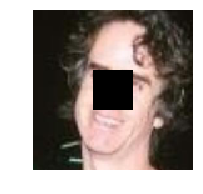

Imágenes de referencia
(1, 128, 128, 3)


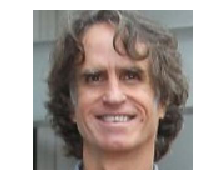

In [6]:
VALIDATION_IDENTITIES = [
  "0005366"
]

validation_images = []
validation_references = []
for identity in VALIDATION_IDENTITIES:
    masked_id_dir = os.path.join(DATASET_PATH, "validation/masked", identity)
    reference_id_dir = os.path.join(DATASET_PATH, "validation/reference", identity)
    mask_image =  plt.imread(os.path.join(masked_id_dir, "024.jpg"))
    reference_image = plt.imread(os.path.join(reference_id_dir, "047.jpg"))
    mask_image = fix_image_encoding(mask_image)
    reference_image = fix_image_encoding(reference_image)
    
    mask_image = resize(mask_image, (IMAGE_SIZE,IMAGE_SIZE))
    reference_image = resize(reference_image, (IMAGE_SIZE,IMAGE_SIZE))
    
    validation_images.append(mask_image)
    validation_references.append(reference_image)

validation_masked_images = []
mask_fn = get_mask_fn(IMAGE_SIZE, PATCH_SIZE)
for mask_image, reference_image in zip(validation_images, validation_references):
  mask_image, _, _ = mask_fn(mask_image, reference_image)
  validation_masked_images.append(mask_image)

validation_images = np.array(validation_images).astype('float32')
validation_references = np.array(validation_references).astype('float32')
validation_masked_images = np.array(validation_masked_images).astype('float32')

print("Imágenes enmascaradas")
print(validation_masked_images.shape)
show_images(validation_masked_images)

print("Imágenes de referencia")
print(validation_references.shape)
show_images(validation_references)

## Levantar saved model en python y ejecutarlo

INFO:tensorflow:Restoring parameters from /home/gaston/workspace/two-face/two-face-inpainting-experiments/local-runs/save_model_test_3/saved_model/variables/variables
(128, 128, 3)


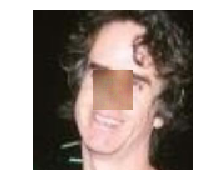

In [7]:
graph = tf.Graph() 
with graph.as_default():
  with tf.Session() as sess:
    metagraph = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], SAVE_MODEL_DIR)
    
    inputs_mapping = dict(metagraph.signature_def['serving_default'].inputs)
    outputs_mapping = dict(metagraph.signature_def['serving_default'].outputs)
    
    masked_image_name = inputs_mapping['masked_image'].name
    reference_image_name = inputs_mapping['reference_image'].name
    output_image_name = outputs_mapping['output_image'].name
    
    result = sess.run(output_image_name, {masked_image_name : validation_masked_images, reference_image_name : validation_references})

    print(result[0].shape)
    show_images(result)

## Probar saved model por HTTP
Se debe levantar aparte el saved model como tf serving

In [29]:
validation_masked_images_json = json.dumps(validation_masked_images.tolist(), separators=(',', ':'))
validation_references_json = json.dumps(validation_references.tolist(), separators=(',', ':'))

In [30]:
r = requests.post("http://localhost:8501/v1/models/two_face_model:predict",
                  data='{"inputs": {"masked_image":' + validation_masked_images_json + ', "reference_image":' + validation_references_json + '}}')

In [31]:
 print(r.status_code, r.reason)

200 OK


In [32]:
result = json.loads(r.text)
result_image = np.array(result['outputs'])

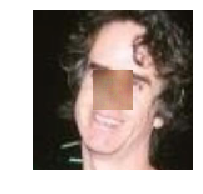

In [33]:
show_images(result_image)